# First RL Gym Project

## 1. Imports

In [8]:
import torch as tr
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np
from environments import BoxEnvironment1 as env
from environment_utils import Box
from agents import SACAgent
from agent_utils import update_target_agent, ReplayBuffer
from log_utils import RLLogger
#from plot_utils import plot_run

device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
tr.autograd.set_detect_anomaly(True)
tr.set_default_tensor_type(tr.FloatTensor)

## 2. Hyperparameters

In [9]:
# ---------------- Training -------------------
    # Memory
memory_size = 256
memory_batch_size = 128 
    # Duration of training
runs = 1
n_episodes = 10
n_steps = 300 + memory_size
    # Training parameters
agent_batch_size = 1
learning_rate = 0.001
learning_rate_decay = 0.8
entropy_coef = 0.2
    # Bellman equation
future_discount = 0.8
    # Update Target Model
target_model_update = n_episodes//10
    # Loss Function
loss_function = nn.MSELoss()

# ---------------- Environment  ----------------
    # Environment box size
env_width = 2
env_height = 2
space = Box(env_width, env_height)
    # Goal box size and center
goal_width = 0.2
goal_height = 0.2
goal_center = np.tile([0.5,0],(agent_batch_size,1))
goal = Box(goal_width, goal_height, goal_center)
    # Time step size
dt = 0.0375
    # Noise
noise_characteristic_length = 1
    # Maximum of potential
U0 = 0.4

# ---------------- Agent ----------------------
state_dim = 5
hidden_dims = [16,16]
act_dim = 1
act_positive = True
act_scaling = 2*np.pi

# ---------------- Other ----------------------
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'figure.dpi': 150})
total_time = []
update_state_time = []

## 3. Simulation

In [10]:
environment = env(space, goal)
memory = ReplayBuffer(state_dim, act_dim, memory_size, agent_batch_size)
agent = SACAgent(state_dim, act_dim, hidden_dims, act_scaling, act_positive).float().to(device)
target_agent = SACAgent(state_dim, act_dim, hidden_dims, act_scaling, act_positive).float().to(device)
logger = RLLogger()

agent.actor_optimizer = tr.optim.Adam(agent.actor.parameters(), lr=learning_rate)
agent.critic1_optimizer = tr.optim.Adam(agent.critic1.parameters(), lr=learning_rate)
agent.critic2_optimizer = tr.optim.Adam(agent.critic2.parameters(), lr=learning_rate)

for p in target_agent.parameters():
    p.requires_grad = False

In [11]:
def update(agent, target_agent, memory_batch):
    state_now = memory_batch['state_now']
    state_next = memory_batch['state_next']
    action_now = memory_batch['action_now']
    reward = memory_batch['reward']
    done = memory_batch['done']
    action_next, log_prob_next = agent.actor(state_next)
    
    # Compute Prediction
    Q1_now = agent.critic1(state_now, action_now)
    Q2_now = agent.critic2(state_now, action_now)
    Q_now = tr.min(Q1_now, Q2_now)

    # Compute Target
    Q1_next = target_agent.critic1(state_next, action_next)
    Q2_next = target_agent.critic2(state_next, action_next)
    Q_next = tr.min(Q1_next, Q2_next)
    Target = reward + future_discount*(Q_next - entropy_coef*log_prob_next)
     
    # Compute Loss
    loss = loss_function(Q_now, Target)
    
    # Update
    loss.backward()
    agent.critic1_optimizer.step()
    agent.critic2_optimizer.step()
    agent.actor_optimizer.step()

    return loss

In [12]:
def episode():    
    environment.init_state(agent_batch_size)
    for current_step in range(n_steps):
        logger.save_state(environment.state)
        if current_step%target_model_update == 0 and current_step > memory_size:
            update_target_agent(agent, target_agent)
        # Beginning state
        state_now = environment.state
        # Action
        action_now, _ = agent.actor(tr.as_tensor(environment.state, device=device, dtype=tr.float))
        # Next state
        environment.step(action_now.detach().cpu().numpy(), U0, dt)
        state_next = environment.state
        # Reward
        reward = environment.reward(dt)
        # Done
        done = environment.goal_check()
        # Store in memory
        memory.store(state_now, action_now, reward, state_next, done)

        # Sample from memory
        if current_step > memory_size:
            memory_batch = memory.sample_batch(memory_batch_size)
            # Update Agent
            loss = update(agent, target_agent, memory_batch)
            logger.save_loss(loss.item())

        if max(environment.goal_check()): 
            print('Goal reached')
            print(f'Enviroment State: {environment.state}')
            logger.save_step(environment.state)
            break
    
    logger.save_episode(current_step)
    return current_step

In [13]:
def simulation():
    update_target_agent(agent, target_agent)
    for ep in range(n_episodes):
        episode_steps = episode()
        logger.save_episode(episode_steps)
        print('Episode', ep,' finished!')

simulation()

Episode 0  finished!
Episode 1  finished!
Episode 2  finished!
Episode 3  finished!
Episode 4  finished!
Episode 5  finished!
Episode 6  finished!
Episode 7  finished!
Episode 8  finished!
Episode 9  finished!


## Plotting


In [16]:
logger.plot_episode_losses()
logger.plot_episode_steps()

<Figure size 960x720 with 0 Axes>

-0.969883255196474 -0.14430251346607917


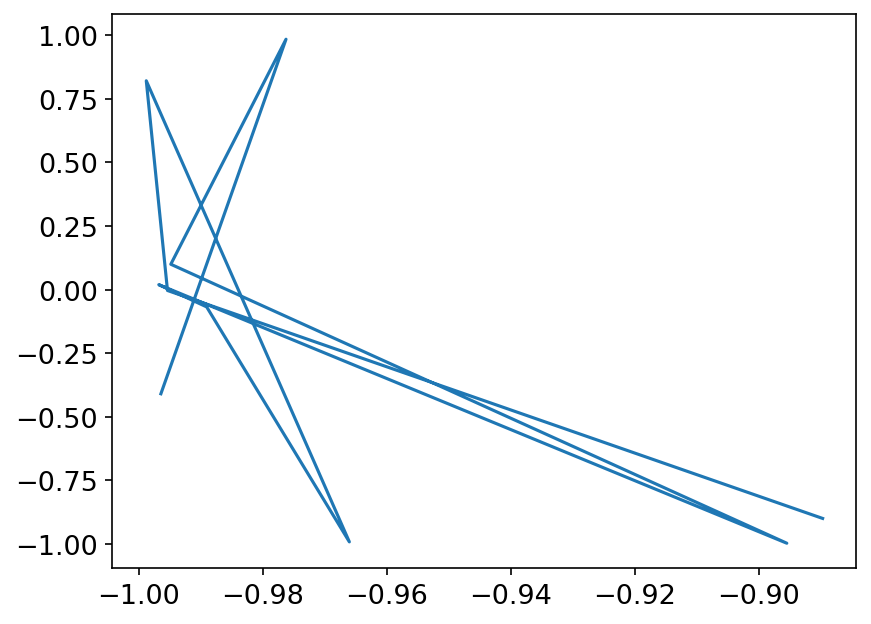

(5560,) (5560,)
min x: -0.9988165263660421, max x: -0.8896713467165295, min y: -0.99678754852495, max y: 0.9845139726530758


In [36]:
actions = []

states = np.stack(logger.states).squeeze()
x = states[:,0]
y = states[:,1]
print(x.mean(), y.mean())
plt.plot(x,y)
plt.show()
print(x.shape, y.shape)
print(f'min x: {min(x)}, max x: {max(x)}, min y: {min(y)}, max y: {max(y)}')
